In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install evaluate
!pip install rouge
!pip install nltk
import pandas as pd
import re
import numpy as np
from pprint import pprint
import evaluate
import time
from rouge import Rouge
import random
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.1 MB/s eta 0:00:00


In [2]:
#Import Base Flair
dfs = {}
for i in range(1,11):
  df_name = "df"+str(i)
  path = '/content/drive/MyDrive/W266 Notes/W266 Final Project/partial files_fullreview/SECTION'+str(i)+'_df_with_sentiment.csv'
  dfs[df_name] = pd.read_csv(path)

full_df = pd.concat(dfs.values(), ignore_index = True)
#Import BoW

dfs = {}
for i in range(1,11):
  df_name = "df"+str(i)
  path = '/content/drive/MyDrive/W266 Notes/W266 Final Project/partial files_BoW/df'+str(i)+'_BoW.csv'
  dfs[df_name] = pd.read_csv(path)

df_BoW = pd.concat(dfs.values(), ignore_index = True)

#Import Textrank Flair
dfs = {}
for i in range(1,11):
  df_name = "df"+str(i)
  path = '/content/drive/MyDrive/W266 Notes/W266 Final Project/partial files_textrank/df'+str(i)+'_textrank.csv'
  dfs[df_name] = pd.read_csv(path)

df_textrank = pd.concat(dfs.values(), ignore_index = True)

#Import spaCy Flair
dfs = {}
for i in range(1,11):
  df_name = "df"+str(i)
  path = '/content/drive/MyDrive/W266 Notes/W266 Final Project/partial files_spacy/df'+str(i)+'_spacy.csv'
  dfs[df_name] = pd.read_csv(path)

df_spacy = pd.concat(dfs.values(), ignore_index = True)

In [3]:
df_spacy.head(1)

,business_id,text_top10,spacy_summary,cleaned_summary,spacy_sentiment,spacy_score
0,-09Oc2D14vRnmirPh0vlXw,[953]\n7/2019\n\nThis Cracker Barrel is locate...,"The food finally makes it to the table, and by...","the food finally makes it to the table, and by...",POSITIVE,1.0


In [4]:
full_df2 = full_df[['business_id', 'text_top10', 'sentiment', 'score']]
joined_df = full_df2.join(df_BoW.set_index('business_id')[['BoW_string', 'BoW_sentiment', 'BoW_score']], on = 'business_id', how = 'left')
joined_df = joined_df.join(df_textrank.set_index('business_id')[['textrank_summary', 'textrank_sentiment', 'textrank_score']], on  = 'business_id', how = 'left')
joined_df = joined_df.join(df_spacy.set_index('business_id')[['spacy_summary', 'spacy_sentiment', 'spacy_score']], on = 'business_id', how = 'left')

#change sign of negative sentiment rows
joined_df.loc[joined_df['sentiment'] == 'NEGATIVE', 'score'] *= -1
joined_df.loc[joined_df['BoW_sentiment'] == 'NEGATIVE', 'BoW_score'] *= -1
joined_df.loc[joined_df['textrank_sentiment'] == 'NEGATIVE', 'textrank_score'] *= -1
joined_df.loc[joined_df['spacy_sentiment'] == 'NEGATIVE', 'spacy_score'] *= -1

In [5]:
def f1_metrics(groundtruth, predictions):
  accuracy = round(accuracy_score(groundtruth, predictions),2)
  precision = round(precision_score(groundtruth, predictions, average='weighted', pos_label = 'POSITIVE'),2)
  recall = round(recall_score(groundtruth, predictions, average='weighted'),2)
  f1 = round(f1_score(groundtruth, predictions, average='weighted'),2)

  return (precision, recall, accuracy, f1)

def sentiment_MSE(groundtruth, predictions):
  return round(mean_squared_error(groundtruth, predictions),2)

In [6]:
f1_metrics(joined_df['sentiment'], joined_df['BoW_sentiment'])
f1_metrics(joined_df['sentiment'], joined_df['spacy_sentiment'])
f1_metrics(joined_df['sentiment'], joined_df['textrank_sentiment'])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'POSITIVE') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'POSITIVE') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'POSITIVE') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


(0.7, 0.65, 0.65, 0.67)

In [7]:
joined_df.BoW_sentiment.describe()

count        10318
unique           2
top       POSITIVE
freq          8734
Name: BoW_sentiment, dtype: object

In [8]:
joined_df.columns

Index(['business_id', 'text_top10', 'sentiment', 'score', 'BoW_string',
       'BoW_sentiment', 'BoW_score', 'textrank_summary', 'textrank_sentiment',
       'textrank_score', 'spacy_summary', 'spacy_sentiment', 'spacy_score'],
      dtype='object')

In [9]:
sentiment_MSE(joined_df['score'], joined_df['spacy_score'])

1.17

In [10]:
bart_path = '/content/drive/MyDrive/W266 Notes/W266 Final Project/BART_gridsearch_2.csv'
bart_summary = pd.read_csv(bart_path, header=0)
bart_summary.head()

bart_joined = bart_summary.join(full_df2.set_index('business_id')[['sentiment', 'score']], on = 'business_id', how = 'left')
bart_joined.loc[bart_joined['sentiment'] == 'NEGATIVE', 'score'] *= -1
bart_joined.loc[bart_joined['BART_sentiment'] == 'NEGATIVE', 'BART_score'] *= -1

In [11]:
bart_joined
print(f1_metrics(bart_joined['sentiment'], bart_joined['BART_sentiment']))
print(sentiment_MSE(bart_joined['BART_score'], bart_joined['score']))

(0.83, 0.79, 0.79, 0.81)
0.76


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'POSITIVE') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [12]:
bart_joined.head(20)

,business_id,text_top10,bart_summary,beam_size,no_repeat_ngrams,BART_sentiment,BART_score,sentiment,score
0,hHzKMfJe7uuw_7WIEHEwBQ,Well I haven't been to PJs oyster bar since th...,PJ's oyster bar has moved to the same location...,1,3,NEGATIVE,-0.990,NEGATIVE,-0.999
1,49dVbKxmhJ08KGH--9getA,I kind of mulled over this review for the bett...,"Ramen Sho is a hidden gem in Boise, Idaho. The...",1,3,NEGATIVE,-0.996,NEGATIVE,-0.899
2,WNqqyUtEmrqCBEHNV9sj5Q,First time visit to Bordentown and Marcellos! ...,Marcello's is a great Italian restaurant in Bo...,1,3,POSITIVE,0.953,POSITIVE,1.000
3,V66EXhrxKanesMhoOqsORw,This was great! It's a wonderful find in a pre...,Shorty's Sunflower Cafe is a great find in a d...,1,3,POSITIVE,0.964,POSITIVE,1.000
4,YVvm1Q3ir5TET0f66FOX_g,Hands down the most authentic Italian restaura...,"La Terrazza is a small, intimate Italian resta...",1,3,POSITIVE,0.998,POSITIVE,1.000
5,b2Tr2RnakZxZxtZpxJ4puw,"This place has so much character, you feel it ...","The California Burger is a solid burger, but t...",1,3,NEGATIVE,-0.967,POSITIVE,0.998
6,1ivYXPfJCuOrh3O0lTW_Jg,Well we went next door to the Joint and saw th...,"Sunny Street Café is the brunch hotspot, and m...",1,3,POSITIVE,0.997,POSITIVE,1.000
7,QUyLaPjsoZiRJ-RUBVa5rA,I have been feeling super bitten by the travel...,The Floribbean is a takeout restaurant in the ...,1,3,POSITIVE,1.000,POSITIVE,1.000
8,XeLAOIv2Ky1wyzIjoTa3Mg,Love this little spot on Broad and it's pretty...,"Coffee Science is available for coffee, non-al...",1,3,POSITIVE,0.999,POSITIVE,1.000
9,nk96iwJV1_p2HECYQW1ysA,After learning that the best way to view the u...,French Quarter Phantoms is located at the back...,1,3,POSITIVE,0.973,POSITIVE,0.998


In [13]:
bart_summary.shape

(900, 7)

In [16]:
joined_df.columns

Index(['business_id', 'text_top10', 'sentiment', 'score', 'BoW_string',
       'BoW_sentiment', 'BoW_score', 'textrank_summary', 'textrank_sentiment',
       'textrank_score', 'spacy_summary', 'spacy_sentiment', 'spacy_score'],
      dtype='object')

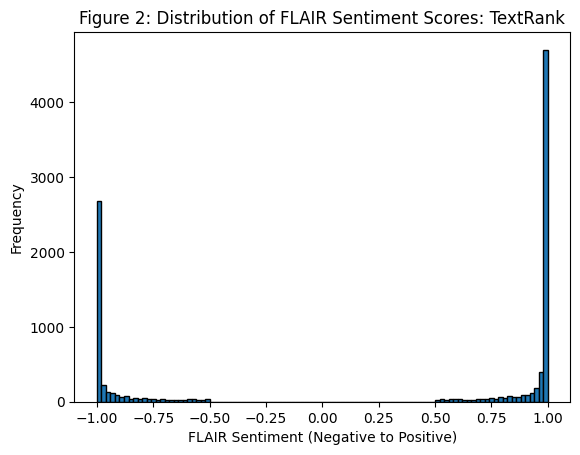

In [23]:
plt.hist(joined_df['textrank_score'], bins=100, range=(-1, 1), edgecolor='black')
plt.xlabel('FLAIR Sentiment (Negative to Positive)')
plt.ylabel('Frequency')
plt.title('Figure 2: Distribution of FLAIR Sentiment Scores: TextRank')
plt.show()

In [26]:
full_df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id',
       'review_stars', 'useful', 'funny', 'cool', 'text_top10', 'date', 'year',
       'review_words', 'cleaned_review', 'sentiment', 'score'],
      dtype='object')

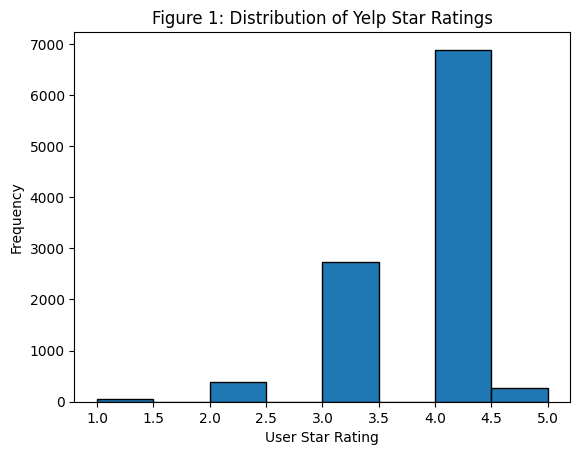

In [37]:
plt.hist(full_df['stars'], bins=8, range=(1, 5), edgecolor='black')
plt.xlabel('User Star Rating')
plt.ylabel('Frequency')
plt.title('Figure 1: Distribution of Yelp Star Ratings')
plt.show()